In [ ]:
# Import packages
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import random

In [ ]:
## Function declarations

# Function to implement k-means
# k is the number of clusters, MAX_ITER is the maximum number of interation
# Some other specifications: 
# 1. dataset is assumed to only have continuous features;
# 2. should have no class variable in the dataset passed in;
# 3. return a dataframe object with class variable;
# 4. objective functions used can be specified, including 'Euclidean', 'Manhattan', 'inf_norm'
# 5. may select 'random' or 'k_meanspp' initial centroids assignment
def K_means(df, k, MAX_ITER, obj='Euclidean', initial='random'): 
    #Initialization
    current_iter = 0 # keep track of iteration count
    n_samples = df.shape[0] # number of samples
    n_features = df.shape[1] # number of features
    
    if initial == 'random':
        k_centroids = df.sample(n=k).reset_index(drop=True) # Let k_centroids be a list of centroids with its own index
    elif initial == 'k-means++':
        # Pick first centroid at random
        k_centroids = df.sample(n=1)
        for i in range(1, k, 1):
            # Calculate distance to each centroid
            closest_centroids = df.apply(lambda x: closest_centroid(x, k_centroids, obj), axis=1)
            closest_centroids = closest_centroids.rename('centroid')
            df_dist = pd.concat([df, closest_centroids], axis=1)
            dist = df_dist.apply(lambda x: cal_dist(df, x.name, x['centroid'], obj), axis=1)
            # Make weight of each point being selected the distance squared to the nearest centroid
            weights = dist.multiply(dist)
            # Select the next centroid in random
            centroid = df.sample(n=1, weights=weights)
            k_centroids = k_centroids.append(centroid)
        k_centroids = k_centroids.reset_index(drop=True) # Let k_centroids be a list of centroids with its own index
        
    df = pd.concat([df, pd.DataFrame(np.zeros((n_samples, 1), dtype=np.int8), index=df.index, columns=['cluster'])], axis=1)
    
    # Iterate until convergence or reaching MAX_ITER or centroids do not move
    for i in range(MAX_ITER):
        # Assign each point to its closest centroid
        df['cluster'] = df.apply(lambda x: closest_centroid(x[:-1], k_centroids, obj), axis=1)
        # Calculate the new centroids, if centroids do not move, break loop
        temp = k_centroids.copy()
        df.groupby('cluster').apply(update_centroid, k_centroids)
        if temp.equals(k_centroids):
            break;
    return df.sort_values('cluster')


# Function that returns the closest centroid a data object belongs to, 
# given a data object, the set of k-centroids, and the objective function.
# Possible objective funtions are 'Euclidean', 'Manhattan', 'inf_norm'
def closest_centroid(instance, k_centroids, obj):    
    raw_dist = k_centroids.sub(instance, axis=1)
    if obj == 'Euclidean':
        dist = np.sqrt(raw_dist.multiply(raw_dist).apply(np.sum, axis=1)) 
    elif obj == 'Manhattan':
        dist = raw_dist.abs().apply(np.sum, axis=1)    
    elif obj == 'inf_norm':
        dist = raw_dist.abs().apply(lambda x: x.max(), axis=1)    
    return dist.idxmin()


# Function to calculate the new centroid given the clustering.
def update_centroid(df, k_centroids):
    cluster_num = df['cluster'].iloc[0]
    temp = df.apply(lambda x: x.mean(), axis=0)
    k_centroids.loc[cluster_num] = temp
    
    
## Function declaration for bisecting k-means
# Function to calculate the SSE of a specific clustering
def calculate_SSE(df):
    centroid = df.mean(axis=0)
    SSE = df.apply(lambda x: x.sub(centroid).dot(x.sub(centroid)), axis=1)
    return SSE.sum()


# Function to implement bisecting k-means
# k is the number of clusters, MAX_ITER is the maximum number of interation (defined again), 
# NUM_TRAILS is the number of basic k-means performed when bisecting the selected cluster
# Some other specifications: 
# 1. dataset is assumed to only have continuous features;
# 2. should have no class variable in the dataset passed in;
# 3. return a dataframe object with class variable;
# 4. objective functions used can be specified, including 'Euclidean', 'Manhattan', 'inf_norm'
def bisecting_kmeans(df, k, trials, obj):
    # Initial cluster
    n_samples = df.shape[0]
    clusters = pd.concat([df, pd.DataFrame(np.zeros((n_samples, 1), dtype=np.int8), columns=['cluster'])], axis=1)
    
    # Repeat until we have k clusters
    for i in range(1, k, 1):
        # Choose to remove the cluster with largest SSE, split on that cluster
        SSE = clusters[:-1].groupby('cluster').apply(calculate_SSE)
        idx_remove = SSE.idxmax()
        cluster = clusters[clusters['cluster'] == idx_remove]
        remain = (clusters[~clusters['cluster'].isin(cluster['cluster'])])
        
        # Dataframe to store the best two clusters
        cluster1 = pd.DataFrame()
        cluster2 = pd.DataFrame()
        min_SSE = SSE.max()
        
        for j in range(trials):
            # Apply basic k-means to split the selected cluster into two
            two_cluster = K_means(cluster.iloc[slice(None),:-1], 2, MAX_ITER, OBJECT)
            two_SSE = two_cluster[:-1].groupby('cluster').apply(calculate_SSE)
            SSE = two_SSE.sum()
            # Store the clusters if the SSE for the new cluster is smaller than the previous trials
            if SSE < min_SSE:
                cluster1 = two_cluster[two_cluster['cluster'] == 0]
                cluster2 = two_cluster[two_cluster['cluster'] == 1]
            min_SSE = SSE
        
        # Add the two clusters back to the original list
        cluster1 = cluster1.assign(cluster=idx_remove)
        cluster2 = cluster2.assign(cluster=i)
        clusters = pd.concat([remain, cluster1, cluster2], axis=0)
    return clusters.sort_values('cluster')
    
    
# Function to calculate the distance between two points given the indexes
def cal_dist(df, idx1, idx2, obj):
    raw_dist = df.loc[idx1].sub(df.loc[idx2])
    #print(raw_dist)
    if obj == 'Euclidean':
        dist = np.sqrt(raw_dist.multiply(raw_dist).sum())
    elif obj == 'Manhattan':
        dist = raw_dist.abs().sum()  
    elif obj == 'inf_norm':
        dist = raw_dist.abs().max()
    return dist


# Function to scale a dataset
def scale_data(df):
    max = df.apply(lambda x: x.max(), axis=0)
    min = df.apply(lambda x: x.min(), axis=0)
    for i in range(df.shape[1]):
        df.iloc[slice(None), i] = (df.iloc[slice(None), i] - min.iloc[i]) / (max.iloc[i] - min.iloc[i])
    return df


# Function to print output to the console
def output(clusters, data_file, tech, scale, n_iterations):
    n_samples = clusters.shape[0]
    n_features = clusters.shape[1]
    n_clusters = clusters['cluster'].nunique()
    count = clusters.groupby('cluster').count()
    count = count['SepalLengthCm'].rename('count')
    SSE = clusters.groupby('cluster').apply(calculate_SSE)
    
    print('The dataset used to test my implementation is: ' + data_file + '\n')
    print('The clustering technique used is: ' + tech + '\n')
    print('The data has been scaled? ' + str(scale) + '\n')
    print('Number of cluster chosen to cluster this dataset is: ' + str(n_clusters) + '\n')
    print('Number of max iterations to cluster this dataset is: ' + str(n_iterations) + '\n')
    print('After applying the clustering technique to the dataset, a sample of the clusters can be seen below: ')
    print(clusters.sample(n=8).sort_index())
    print('\nThe number of instances in each cluster is shown below: ')
    print(count)
    print('\nThe intracluster SSE is: ')
    print(SSE)
    print('\nThe total SSE is: ' + "{:.2f}".format(SSE.sum()))


In [ ]:
## Test K-means algorithm
MAX_ITER = 300
NUM_TRIALS = 5
OBJECT = 'Euclidean'
INITIAL = 'k-means++'
scale = True
k = 3
    
data_file = 'data/Iris_student.csv'
raw_data = pd.read_csv(data_file)

# Data preprocessing
clean_data = raw_data.iloc[slice(None), 1:].copy()
# Scale option
if scale:
    clean_data = scale_data(clean_data)

# Apply k-means algorithm to clustering based on the features
k_clusters = K_means(clean_data, k, MAX_ITER, OBJECT, INITIAL)
#output(k_clusters, data_file, 'basic k-means', scale, MAX_ITER)


# Apply bisecting k-means algorithm to clustering based on the features
bisecting_clusters = bisecting_kmeans(clean_data, k, NUM_TRIALS, OBJECT)
output(bisecting_clusters, 'bisecting k-means', scale, MAX_ITER)

TypeError: output() missing 1 required positional argument: 'n_iterations'

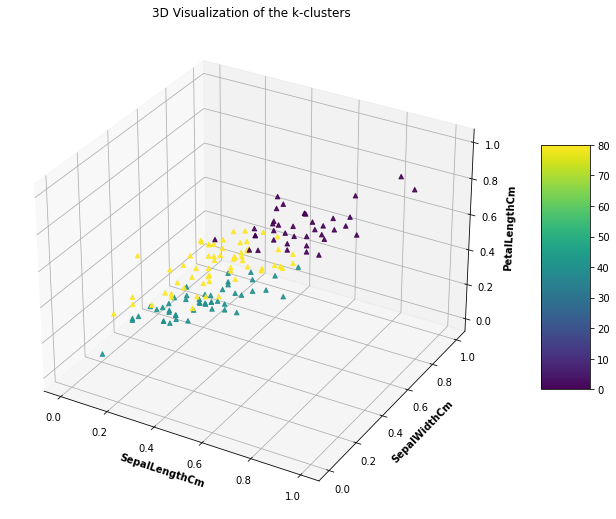

In [ ]:
# Visualize the clusters using 3 features
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

my_cmap = plt.get_cmap('viridis')
sctt = ax.scatter3D(k_clusters['SepalLengthCm'], 
                    k_clusters['SepalWidthCm'], 
                    k_clusters['PetalLengthCm'], 
                    alpha = 0.9,
                    c = k_clusters['cluster'] * 40,
                    cmap = my_cmap,
                    marker ='^')

plt.title("3D Visualization of the k-clusters")
ax.set_xlabel('SepalLengthCm', fontweight ='bold')
ax.set_ylabel('SepalWidthCm', fontweight ='bold')
ax.set_zlabel('PetalLengthCm', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

The graph-based cohesion for cluster 0 is: 224.62005726511995
The graph-based cohesion for cluster 1 is: 290.99560752714666
The graph-based cohesion for cluster 2 is: 539.4153873587109
Total graph-based cohesion is: 1055.0310521509775

The graph-based separation for cluster 0 and cluster 1 is: 3058.280226148779
The graph-based separation for cluster 0 and cluster 2 is: 4942.726676226981
The graph-based separation for cluster 1 and cluster 2 is: 3984.6982943581843
Total graph-based separation is: 11985.705196733945

Silhouette coefficient for the 0 cluster is: 0.7478626757702308
Silhouette coefficient for the 1 cluster is: 0.7137273174755104
Silhouette coefficient for the 2 cluster is: 0.6115547503394059
Average Silhouette coefficient is: 0.6910482478617158

The correlation graph is calculated as below


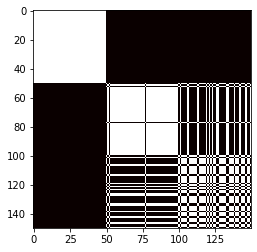

In [ ]:
## Evaluate the final clusters, given k_clusters

# Calculate the centroids
centroids = k_clusters.groupby('cluster').apply(lambda x: x.mean())
centroids = centroids.iloc[slice(None), :-1]
n_clusters = centroids.shape[0]

# Cohesion
cohesion = 0
for i in range(n_clusters):
    temp = k_clusters[k_clusters['cluster'] == i]
    temp_cohesion = 0
    temp_samples = temp.shape[0]
    
    for j in range(temp_samples):
        for k in range(j, temp_samples, 1):
            temp_cohesion += np.sqrt(((temp.iloc[j] - temp.iloc[k]) ** 2).sum())
    cohesion += temp_cohesion
    print('The graph-based cohesion for cluster ' + str(i) + ' is: ' + str(temp_cohesion))
print('Total graph-based cohesion is: ' + str(cohesion) + '\n')

# Seperation
separation = 0
for i in range(n_clusters):
    for j in range(i+1, n_clusters, 1):
        temp1 = k_clusters[k_clusters['cluster'] == i]
        temp2 = k_clusters[k_clusters['cluster'] == j]
        temp_separation = 0
        
        for k in range(temp1.shape[0]):
            for l in range(temp2.shape[0]):
                temp_separation += np.sqrt(((temp1.iloc[k] - temp2.iloc[l]) ** 2).sum())
                
        separation += temp_separation
        print('The graph-based separation for cluster ' + str(i) + ' and cluster ' + str(j) + ' is: ' + str(temp_separation))
print('Total graph-based separation is: ' + str(separation) + '\n')

# Silhouette Coefficient
silhouette = 0
for i in range(n_clusters):
    temp_silhouette = 0
    temp = k_clusters[k_clusters['cluster'] == i]
    
    a = 0
    n = 0
    for j in range(temp.shape[0]):
        for k in range(j, temp.shape[0], 1):
            a += np.sqrt(((temp.iloc[j] - temp.iloc[k]) ** 2).sum())
            n += 1
    a = a / n
    
    b = 0
    n = 0
    b_min = 40000
    remain = k_clusters[k_clusters['cluster'] != i]
    for j in range(n_clusters):
        if j != i:
            temp1 = k_clusters[k_clusters['cluster'] == i]
            temp2 = k_clusters[k_clusters['cluster'] == j]
            for k in range(temp1.shape[0]):
                for l in range(temp2.shape[0]):
                    b += np.sqrt(((temp1.iloc[k] - temp2.iloc[l]) ** 2).sum())
                    n += 1
            b = b / n
            if b <= b_min: 
                b_min = b
    temp_silhouette = (b_min - a) / np.max([a, b_min])
    silhouette += temp_silhouette
    print('Silhouette coefficient for the ' + str(i) + ' cluster is: ' + str(temp_silhouette))
silhouette = silhouette / n_clusters
print('Average Silhouette coefficient is: ' + str(silhouette) + '\n')
    
# Correlation
sorted_clusters = k_clusters.sort_values('cluster')
n_samples = sorted_clusters.shape[0]
corr = pd.DataFrame(np.zeros((n_samples, n_samples)), dtype=np.int8)
for i in range(n_samples):
    for j in range(n_samples):
        if sorted_clusters.loc[i, 'cluster'] == sorted_clusters.loc[j, 'cluster']:
            corr.iloc[i][[j]] = 1
        else:
            corr.iloc[i][[j]] = 0
print('The correlation graph is calculated as below')
plt.imshow(corr, cmap='hot', interpolation='nearest')
plt.show()



In [ ]:
## Function Declaration for Hierarchical Clustering

# Function to calculate the distance between a two clusters
def cal_dist(df, measure, idx_list1, idx_list2):
    min_dist = 1000000
    max_dist = 0
    dist_avg = 0
    if measure == 'single':
        for i in idx_list1:
            for j in idx_list2:
                temp_dist = np.sqrt(((df.iloc[int(i)] - df.iloc[int(j)]) ** 2).sum())
                if temp_dist < min_dist:
                    min_dist = temp_dist
                    #print(min_dist)
        return min_dist
    elif measure == 'complete':
        for i in idx_list1:
            for j in idx_list2:
                temp_dist = np.sqrt(((df.iloc[int(i)] - df.iloc[int(j)]) ** 2).sum())
                if temp_dist > max_dist:
                    max_dist = temp_dist
        return max_dist
    elif measure == 'group_avg':
        for i in idx_list1:
            for j in idx_list2:
                temp_dist = np.sqrt(((df.iloc[int(i)] - df.iloc[int(j)]) ** 2).sum())
                dist_avg += temp_dist
        dist_avg = dist_avg / (len(idx_list1) * len(idx_list2))
        return dist_avg    

# Function to cluster a dataset using the given measure
# Possible measure includes 'single', 'complete', 'group_avg'
def hierarchical(df, measure):
    h_cluster = []
    n_samples = df.shape[0]
    prox_matrix = pd.DataFrame(np.zeros((n_samples, n_samples)), index=range(n_samples), columns=range(n_samples), dtype=np.float32)
    prox_matrix.index = prox_matrix.index.astype(str)
    prox_matrix.columns = prox_matrix.columns.astype(str)
    h_cluster.append(prox_matrix.index.to_list())
    while prox_matrix.shape[0] > 1:  
        temp_cluster = []
        # Calculate/update proximity matrix, also record the min value
        min_entry = 1000000
        for i in prox_matrix.index:
            for j in prox_matrix.columns:
                temp_i = i.split(',')
                temp_j = j.split(',')
                temp_dist = cal_dist(df, measure, temp_i, temp_j)
                prox_matrix.loc[i, j] = temp_dist
                if temp_dist < min_entry and i != j:
                    min_entry = temp_dist
                    temp_index = i
                    temp_column = j
        temp_cluster = prox_matrix.index.to_list()
        temp_cluster.remove(temp_index)
        temp_cluster.remove(temp_column)
        temp_cluster.append(temp_index + ',' + temp_column)
        h_cluster.append(temp_cluster.copy())
        prox_matrix = pd.DataFrame(np.zeros((len(temp_cluster), len(temp_cluster))), index=temp_cluster, columns=temp_cluster, dtype=np.float32)
    return h_cluster


# Execute Hierarchical Clustering 
data_file2 = 'data/separated_2d.csv'
raw_data2 = pd.read_csv(data_file2)


## Test hierarchical clustering
clean_data2 = raw_data2.iloc[slice(None), 1:].copy()
# Scale option
if scale:
    clean_data2 = scale_data(clean_data2)

h_clusters = hierarchical(clean_data2, 'group_avg')

# Show output
for i in range(5):
    rand = random.randint(0, len(h_clusters)-1)
    print(h_clusters[rand])


In [ ]:
# More on hierarchy (k=3)
clusters_5 = h_clusters[58]
count = 0
clean_data2_temp = clean_data2.copy()
clean_data2_temp['cluster'] = 0
for i in clusters_5:
    temp = i.split(',')
    for j in temp:
        clean_data2_temp.loc[int(j), 'cluster'] = count
    count += 1


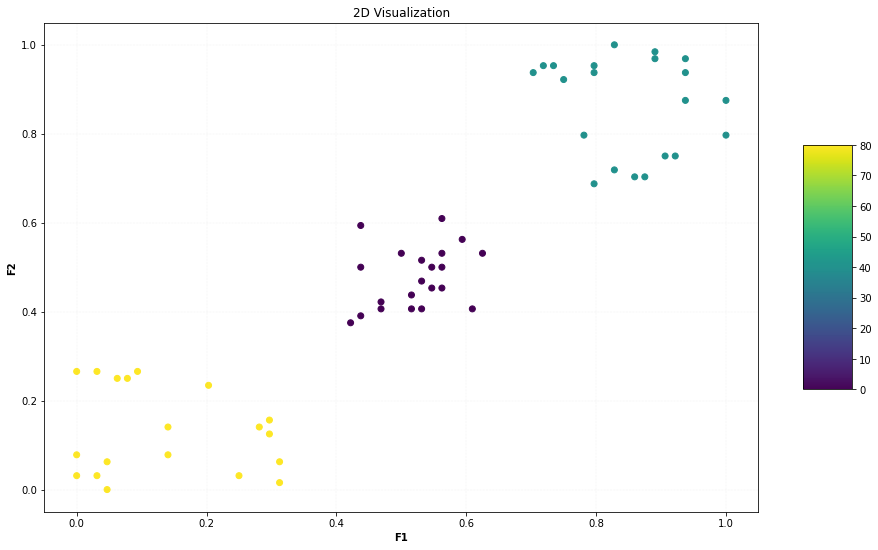

In [ ]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes()

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

my_cmap = plt.get_cmap('viridis')
scat = plt.scatter(clean_data2_temp['F1'], clean_data2_temp['F2'], c=clean_data2_temp['cluster'] * 40, marker=None, cmap=my_cmap)
plt.title("2D Visualization")
ax.set_xlabel('F1', fontweight ='bold')
ax.set_ylabel('F2', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()